## Brooklyn accessibility analysis


In [202]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import contextily as ctx

sns.set('notebook', font_scale=1.1, rc={'figure.figsize': (10, 5)})
sns.set_style('ticks', rc={'figure.facecolor': 'none', 'axes.facecolor': 'none'})
%config InlineBackend.figure_format = 'svg'

import warnings
warnings.filterwarnings('ignore')

### 0. Load dataset and preprocessing

> **INFO**
> - `GEOID` is the unique identifier for every block


In [208]:
# Load
df_pop = pd.read_csv('data/pop_count.csv')
df_blocks = gpd.read_file('data/bg_3_mo/bg_3_mo.shp')

# Preprocess
df_pop['GEOID'] = df_pop['GEOID'].str.split('US').str[1]

# Add population per census block group
df_blocks = pd.merge(df_blocks, df_pop[['GEOID', 'pop_tot']], on='GEOID', how='left')

df_blocks['trans_agg'] = df_blocks['num_bike'] + df_blocks['num_bus'] + df_blocks['num_bike']
df_blocks = df_blocks.rename(columns={'col_1': 'nycha', 'num_subs': 'Subway stations', 'num_bus': 'Bus stations', 
                                      'num_bike': 'Bike racks', 'pop_tot': 'Population'})

mapping_dict = {np.nan: False, 1: True}
df_blocks['nycha'] = df_blocks['nycha'].map(mapping_dict)
# Add area of census block groups
df_blocks.to_crs(epsg=4326, inplace=True)
df_blocks['Area'] = df_blocks['geometry'].area

selected_columns = ['GEOID', 'Subway stations', 'Bus stations', 'Bike racks', 'nycha', 'Area', 'Population', 'geometry']

df_blocks = df_blocks[selected_columns]

# Drop rows with missing population data
df_blocks = df_blocks.dropna(subset=['Population'], inplace=False)

df_blocks['Subway stations'].fillna(0, inplace=True)
df_blocks['Bus stations'].fillna(0, inplace=True)
df_blocks['Bike racks'].fillna(0, inplace=True)

In [209]:
df_blocks.shape

(2146, 8)

In [210]:
df_blocks.head()

,GEOID,Subway stations,Bus stations,Bike racks,nycha,Area,Population,geometry
1,360470069022,0.0,0.0,1.0,False,0.000006,1239.0,"POLYGON ((-73.99458 40.68510, -73.99441 40.685..."
2,360470069011,1.0,0.0,1.0,False,0.000004,798.0,"POLYGON ((-73.99090 40.68608, -73.99047 40.686..."
3,360470069021,0.0,0.0,0.0,False,0.000005,943.0,"POLYGON ((-73.99219 40.68418, -73.99176 40.684..."
4,360470337011,0.0,1.0,2.0,False,0.000005,1293.0,"POLYGON ((-73.94771 40.66992, -73.94765 40.670..."
5,360470337021,0.0,0.0,0.0,False,0.000005,815.0,"POLYGON ((-73.94775 40.66950, -73.94773 40.669..."


In [206]:
df_blocks['nycha'].value_counts()

nycha
False    2029
True      117
Name: count, dtype: int64

In [227]:
def weighted_mean(df, value, weight):
    if weight == 'Unweighted':
        return df[value].mean()
    return (df[value] * df[weight]).sum() / df[weight].sum()

Compare:
1. $\mu_{\text{nycha}}$
2. $\mu_{\text{non-nycha}}$

Testing framework:
- **H0:** Number of transportation facilities of type X equal in Nycha neighbourhoods compared to non-Nycha neighbourhoods, that is, $\mu_{\text{nycha}} = \mu_{\text{non-nycha}}$

- **H1:** Not H0; $\mu_{\text{nycha}} \neq \mu_{\text{non-nycha}}$

Steps:
1. Compute average number of facilities (for comparable populations, in this case neighbourhoods)
2. Compute difference between average number of facilities, $\delta = \mu_{\text{nycha}} - \mu_{\text{non-nycha}}$
3. Assuming the number of facilities follow a normal distribution with the same variance for the Nycha and non-Nycha neighbourhoods, the hypothesis can be tested using a standard t-test (useful link: https://en.wikipedia.org/wiki/Student%27s_t-test)

In [214]:
df_blocks_plot

nycha
Non-Nycha    0.000008
Nycha        0.000008
dtype: float64

In [218]:
df_blocks_plot

nycha
Non-Nycha    0.080335
Nycha        0.051282
dtype: float64

In [219]:
df_blocks_plot['Non-Nycha']

0.08033514046328241

In [241]:
axs[]

<Axes: title={'center': 'Unweighted'}, ylabel='Values'>

In [ ]:
df_blocks_plot.plot(kind='bar', ax=axs[0], title=f'{value} weighted by {weight}' if weight != 'Unweighted' else f'{value}')

0


,Average
nycha,
Non-Nycha,0.08
Nycha,0.05


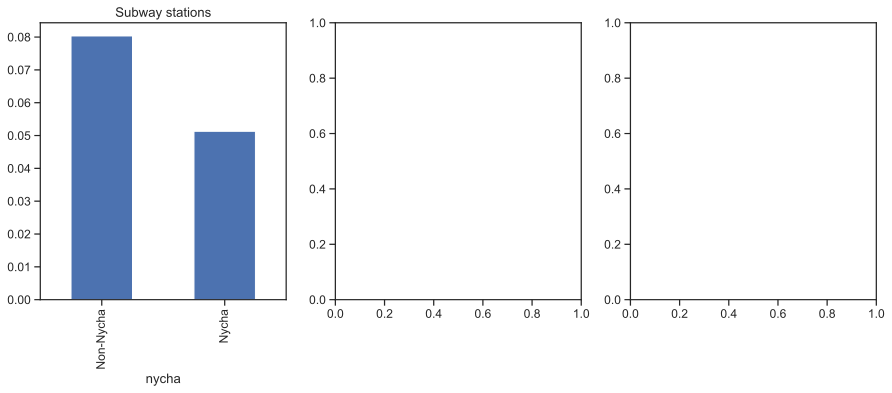

1


,Average
nycha,
Non-Nycha,0.09
Nycha,0.04


2


,Average
nycha,
Non-Nycha,0.09
Nycha,0.04


0


,Average
nycha,
Non-Nycha,0.39
Nycha,0.74


1


,Average
nycha,
Non-Nycha,0.84
Nycha,1.12


2


,Average
nycha,
Non-Nycha,0.42
Nycha,0.71


0


,Average
nycha,
Non-Nycha,0.31
Nycha,0.34


1


,Average
nycha,
Non-Nycha,0.59
Nycha,0.35


2


,Average
nycha,
Non-Nycha,0.32
Nycha,0.37


In [247]:
# Unweighted, Weighted by area, Weighted by population
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

def weighted_mean(df, value, weight):
    if weight == 'Unweighted':
        return df[value].mean()
    return (df[value] * df[weight]).sum() / df[weight].sum()

for value in ['Subway stations', 'Bus stations', 'Bike racks']:
    for idx, weight in enumerate(['Unweighted', 'Area', 'Population']):
        print(idx)
        if value == weight:
            continue
        
        df_blocks_plot = df_blocks.assign(
            nycha=df_blocks['nycha'].apply(lambda val: 'Nycha' if val==1 else 'Non-Nycha')
        ).groupby(by='nycha').apply(
            lambda df: weighted_mean(df, value, weight=weight)
        )
        #display(df_blocks_plot.to_frame('Average').style.format(precision=2).set_caption(f'{value} weighted by {weight}'))
        df_blocks_plot.plot(kind='bar', ax=axs[idx], title=f'{value} weighted by {weight}' if weight != 'Unweighted' else f'{value}', stacked=True)
    plt.show()

- Report percentual differences 

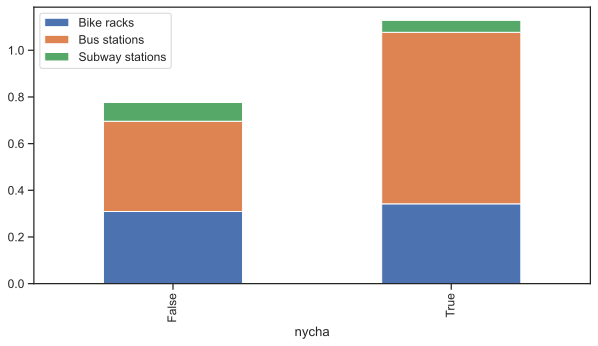

In [184]:
fig, ax = plt.subplots()
df_blocks.pivot_table(
    index='nycha',
    values=['Subway stations', 'Bus stations', 'Bike racks'],
    aggfunc='mean'
).plot(kind='bar', stacked=True, ax=ax)
plt.show()

### 1. Accessibility analysis

> **RQ:** How does the public transportation accessibility in NYCHA neighborhoods compare to the average neighborhood in Brooklyn?

#### 1.1 Unweighted accessibility

- The average number of transportation modes per census block group
- Let $C = \{ \text{NYCHA}, \text{OTHER} \}$ be the two classes of block groups, then:
\begin{align*}
    \mu_{\text{NYCHA}} = \frac{\sum \text{subway stations in NYCHA blocks} }{\text{total block groups that are NYCHA}}
\end{align*}

\begin{align*}
    \mu_{\text{OTHER}} = \frac{\sum \text{transportation mode in other blocks} }{\text{total block groups that are not NYCHA}}
\end{align*}

In [181]:
agg_list = ['mean', 'count', 'std']

aggregations = {
    'Subway stations': agg_list,
    'Bus stations': agg_list,
    'Bike racks': agg_list,
}

result_table = df_blocks.groupby('nycha').agg(aggregations)
result_table.round(2)

Subway stations             Bus stations             Bike racks        \
                 mean count   std         mean count   std       mean count   
nycha                                                                         
False            0.08  2029  0.29         0.39  2029  0.83       0.31  2029   
True             0.05   117  0.22         0.74   117  0.96       0.34   117   

             
        std  
nycha        
False  0.70  
True   0.66

In [121]:
#print(result_table.to_latex(index=False, formatters={"name": str.upper}, float_format="{:.2f}".format))  

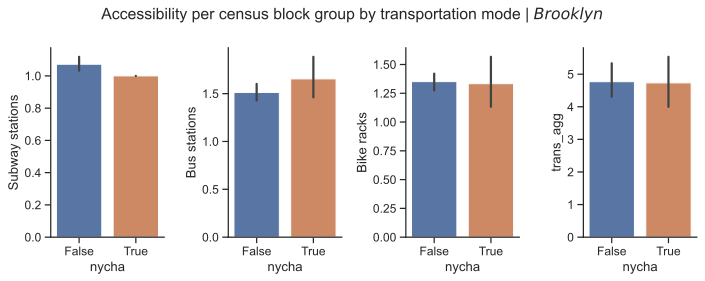

In [128]:
fig, axs = plt.subplots(1, 4, figsize=(10, 4))

fig.suptitle(r'Accessibility per census block group by transportation mode | ${Brooklyn}$')

sns.barplot(df_blocks, y="Subway stations", x="nycha", ax=axs[0], hue="nycha", legend=False)
sns.barplot(df_blocks, y="Bus stations",  x="nycha", ax=axs[1], hue="nycha", legend=False)
sns.barplot(df_blocks, y="Bike racks", x="nycha", ax=axs[2], hue="nycha", legend=False)
sns.barplot(df_blocks, y="trans_agg",  x="nycha", ax=axs[3], hue="nycha", legend=False)

plt.tight_layout()
sns.despine()

plt.savefig('figures/acc_cbg_standard_bar.png', dpi=200);

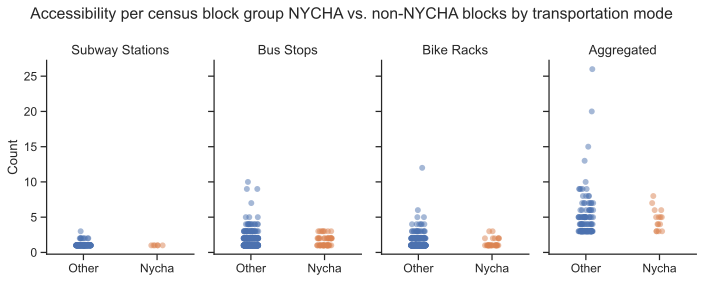

<Figure size 1000x500 with 0 Axes>

In [77]:
fig, axs = plt.subplots(1, 4, figsize=(10, 4), sharey=True)

fig.suptitle(r'Accessibility per census block group NYCHA vs. non-NYCHA blocks by transportation mode')

sns.stripplot(data=df_blocks, y="num_subs",  x="nycha", ax=axs[0], hue="nycha", dodge=False, size=6, alpha=0.5, legend=False)
sns.stripplot(data=df_blocks, y="num_bus",  x="nycha", ax=axs[1], hue="nycha", dodge=False, size=6, alpha=0.5, legend=False)
sns.stripplot(data=df_blocks, y="num_bike", x="nycha", ax=axs[2], hue="nycha", dodge=False, size=6, alpha=0.5, legend=False)
sns.stripplot(data=df_blocks, y="trans_agg",  x="nycha", ax=axs[3], hue="nycha", dodge=False, size=6, alpha=0.5, legend=False)

# Update x labels
for ax in axs:
    ax.set_xticklabels(['Other', 'Nycha'])

# Update y-axis label
for ax in axs:
    ax.set_ylabel('Count')

# Update titles
axs[0].set_title('Subway Stations')
axs[1].set_title('Bus Stops')
axs[2].set_title('Bike Racks')
axs[3].set_title('Aggregated')
axs[0].set_xlabel('')
axs[1].set_xlabel('')
axs[2].set_xlabel('')
axs[3].set_xlabel('')   

plt.tight_layout()
sns.despine()
plt.show()

plt.savefig('figures/accessibility_per_census_block_by_transportation_mode.png', dpi=200);

### 1.2 Make stacked bar chart with average number of stations per mode per block (NYCHA vs. non-NYCHA) weighted by **population**


In [111]:
# Get the total population per block type (NYCHA vs NON-NYCHA)
pop_block_types = dict(df_blocks_pop.groupby('nycha')['pop_tot'].sum())

pop_block_types

{False: 2385990.0, True: 190781.0}

In [114]:
df_total_transport_per_block = df_blocks_pop.groupby('nycha')[['num_subs', 'num_bus', 'num_bike']].sum()

df_total_transport_per_block

,num_subs,num_bus,num_bike
nycha,,,
False,163.0,785.0,627.0
True,6.0,86.0,40.0


In [120]:
df_total_transport_per_block.div(df_total_transport_per_block.index.map(pop_block_types), axis=0) * 10_000

,num_subs,num_bus,num_bike
nycha,,,
False,0.683155,3.290039,2.627840
True,0.314497,4.507786,2.096645


### 1.3 Make stacked bar chart with average number of stations per mode per block (NYCHA vs. non-NYCHA) weighted by **area**

Create a bar graph displaying the number of stations per squared kilometer between 'NYCHA' and 'non-NYCHA' blocks. Steps:

- Calculate the total number of stations ('num_subs', 'num_bus', 'num_bike') for each block type ('NYCHA' and 'non-NYCHA').
- Calculate the total area for each block type ('NYCHA' and 'non-NYCHA').
- Divide the total number of stations by the total area for each block type to get the stations per squared kilometer.
- Plot a bar graph to display the stations per squared kilometer for both block types.

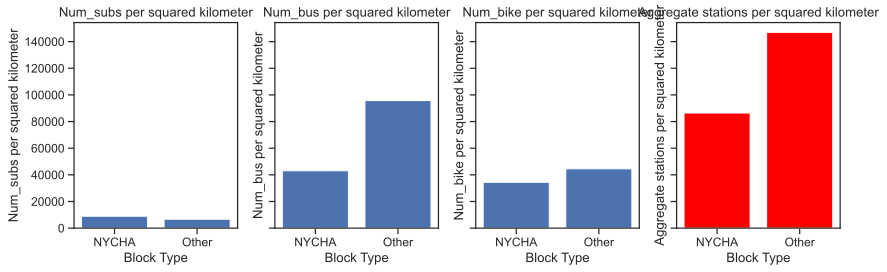

In [56]:
# Calculate stations and area for subway stations, bus stops, and Citibike racks for each block type
stations = ['num_subs', 'num_bus', 'num_bike']
block_types = ['nycha', ~df_blocks['nycha']]

colors = ['blue', 'orange', 'green']

fig, axs = plt.subplots(1, 4, figsize=(12, 4), sharey=True)

for i, station in enumerate(stations):
    station_counts = df_blocks.groupby('nycha')[station].sum()
    area = df_blocks.groupby('nycha')['area'].sum()
    stations_per_sq_km = (station_counts / area).tolist()

    axs[i].bar(['NYCHA', 'Other'], stations_per_sq_km)
    axs[i].set_xlabel('Block Type')
    axs[i].set_ylabel(f'{station.capitalize()} per squared kilometer')
    axs[i].set_title(f'{station.capitalize()} per squared kilometer')

# Calculate aggregate of all stations
aggregate_stations = [sum(x) for x in zip(*[df_blocks.groupby('nycha')[station].sum() / df_blocks.groupby('nycha')['area'].sum() for station in stations])]
axs[3].bar(['NYCHA', 'Other'], aggregate_stations, color='red')
axs[3].set_xlabel('Block Type')
axs[3].set_ylabel('Aggregate stations per squared kilometer')
axs[3].set_title('Aggregate stations per squared kilometer')

plt.tight_layout()
plt.show()


### 1.4 Conclusions